In [1]:
import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
from sklearn import manifold
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from utils import *
# from minepy import MINE
from sklearn.preprocessing import MinMaxScaler

In [2]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

2.1.2
11.8
True
1
0


In [3]:
method = ''
from g2g_model_Fisher import *

In [6]:
model_name = 'sphere'
result_path = 'results/'+model_name+'/'
figure_path = 'figures/'
cmap = plt.colormaps['Spectral_r']

In [7]:
import os

folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path) 

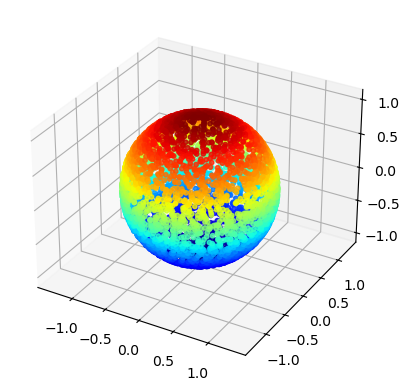

In [53]:
n_samples=5000

g3 = np.random.randn(3,n_samples)
gr = np.linalg.norm(g3,axis=0)

x1,x2,x3 = g3/gr

color_label=np.zeros((n_samples))
color_label[np.argsort(x3)]=np.arange(n_samples)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, x3,  s=10, c=color_label,alpha=0.8,cmap=plt.cm.jet)
# ax.set_aspect('equal')
# ax.set_xlim((-2,2))
# ax.set_ylim((-2,2))
# ax.set_zlim((-2,2))
plt.axis('equal')
plt.show()

X_major=np.array([x1,x2,x3]).T
X_minor=0.2*np.random.randn(n_samples,7)
X=np.hstack((X_major,X_minor))

In [54]:
k_nei = 10
A = kneighbors_graph(X, k_nei, mode='connectivity', include_self=True)
# A=radius_neighbors_graph(X,3,include_self=True)
X_major = X[:,:3]

row =np.array([np.ones((k_nei,))*i for i in range(n_samples)]).flatten()
col=A.indices
w_val=np.array([np.linalg.norm(X_major[int(i),:]-X_major[int(j),:]) for i,j in zip(row,col)])
dc=np.mean(w_val)

cell_nei=A.indices.reshape(X.shape[0],10)
nei_w=[]
rho_arr=[]
for ni in cell_nei:
    dij=np.array([np.linalg.norm(X_major[int(ni[0]),:]-X_major[int(i),:]) for i in ni[1:]])
    rho=np.sum(np.exp(-dij**2/dc**2))
#     rho=np.exp(np.sum(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
#     print(dij)
#     print(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)
nei_w=np.hstack((np.ones((nei_w.shape[0],1)),nei_w))/2

# plt.scatter(X_pca[:,0],X_pca[:,1],s=5,c=rho_arr,cmap=plt.cm.jet)
# plt.colorbar()
# plt.show()

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return X_s

In [10]:
epochs = 200
nsamples = 3
learning_rate = 1e-3
# n_workers = 4
K = 2
L = 3
#     checkpoint_path = args.checkpoint
#     checkpoints_path = args.checkpoints
#     dataset_path = args.dataset

In [11]:
# for i in range(10):
#     reset_seeds(i)
#     A=A.astype(np.float32)
#     X=X.astype(np.float32)
#     z=color_label

#     n = A.shape[0]
#     train_nodes, val_nodes = train_test_split(n, train_ratio=1)
#     A_train = A[train_nodes, :][:, train_nodes]
#     X_train = X[train_nodes]
#     z_train = z[train_nodes]
#     A_val = A[val_nodes, :][:, val_nodes]
#     X_val = X[val_nodes]
#     z_val = z[val_nodes]

#     train_data = AttributedGraph(A_train, X_train, z_train, K)
#     val_data = AttributedGraph(A_val, X_val, z_val, K)
    
#     encoder = Encoder(X.shape[1], L)
#     optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
#     iterations = epochs #// n_workers
#     dataset = GraphDataset(train_data, nsamples, iterations)
#     loader = DataLoader(
#         dataset,
#         batch_size=1,
#         #num_workers=n_workers,
#         worker_init_fn=reset_seeds,
#         collate_fn=lambda args: args,
#     )
    
#     for batch_idx, data in enumerate(loader):
#         encoder.train()
#         optimizer.zero_grad()

#         loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])
#         if batch_idx% 10 == 0:
#             print(batch_idx,loss)
#         loss.backward()
#         optimizer.step()
        
#     torch.save(encoder,result_path+'encoder'+str(i)+'.pt')
    
#     mu, sigma = encoder(torch.FloatTensor(X))
#     X_mu = mu.detach().numpy()
#     X_sigma = sigma.detach().numpy()#The learned sigma is variance

# #     cRc_arr=[]
#     cRc_arr_eu=[]
# #     cRc_arr_mueu=[]
#     mu_learned = X_mu
#     sigma_learned = X_sigma

#     for inds in np.split(A.indices, A.indptr)[1:-1]:
#         self_ind=inds[0]
# #         cRc=0
#         cRc_eu=0
# #         cRc_mueu=0
#         for nei_k in range(1,len(inds)):
#             dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
# #             dMuEu=np.linalg.norm(X_mu[self_ind,:]-X_mu[inds[nei_k],:])
# #             dFi=Fisher_dist(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
# #                             mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])
#             dWa=wasserstein_distance(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
#                             mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])

# #             cRc += 1-dWa/dFi
#             cRc_eu += 1-dWa/dEu
# #             cRc_mueu += 1-dWa/dMuEu

# #         cRc_arr.append(cRc/len(inds))
#         cRc_arr_eu.append(cRc_eu/len(inds))
# #         cRc_arr_mueu.append(cRc_mueu/len(inds))
# #     orc = np.array(cRc_arr)
#     orc_eu = np.array(cRc_arr_eu)
# #     orc_mueu = np.array(cRc_arr_mueu)
    
#     np.save(result_path+'crc'+str(i),orc_eu)

0 tensor(3.6779e+08, grad_fn=<DivBackward0>)
10 tensor(2.2497e+08, grad_fn=<DivBackward0>)
20 tensor(2.0367e+08, grad_fn=<DivBackward0>)
30 tensor(2.0069e+08, grad_fn=<DivBackward0>)
40 tensor(1.9770e+08, grad_fn=<DivBackward0>)
50 tensor(1.9560e+08, grad_fn=<DivBackward0>)
60 tensor(1.9572e+08, grad_fn=<DivBackward0>)
70 tensor(1.9553e+08, grad_fn=<DivBackward0>)
80 tensor(1.9497e+08, grad_fn=<DivBackward0>)
90 tensor(1.9464e+08, grad_fn=<DivBackward0>)
100 tensor(1.9270e+08, grad_fn=<DivBackward0>)
110 tensor(1.9460e+08, grad_fn=<DivBackward0>)
120 tensor(1.9504e+08, grad_fn=<DivBackward0>)
130 tensor(1.9371e+08, grad_fn=<DivBackward0>)
140 tensor(1.9368e+08, grad_fn=<DivBackward0>)
150 tensor(1.9335e+08, grad_fn=<DivBackward0>)
160 tensor(1.9340e+08, grad_fn=<DivBackward0>)
170 tensor(1.9133e+08, grad_fn=<DivBackward0>)
180 tensor(1.9260e+08, grad_fn=<DivBackward0>)
190 tensor(1.9202e+08, grad_fn=<DivBackward0>)
0 tensor(3.7366e+08, grad_fn=<DivBackward0>)
10 tensor(2.1193e+08, grad

In [122]:
# tsne = manifold.TSNE(n_components=3, random_state=0, perplexity=30)
tsne = manifold.TSNE(n_components=3, random_state=0,perplexity=20.0,early_exaggeration=12.0)
S_tsne = tsne.fit_transform(X)

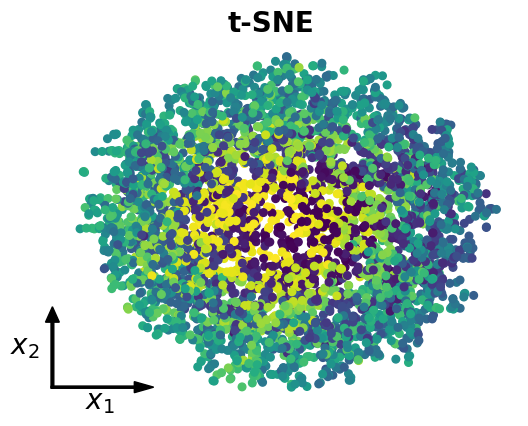

In [123]:
X_plt = S_tsne[:,0]
Y_plt = S_tsne[:,1]
X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min-wid*10
Y_ori = Y_min

plt.scatter(X_plt,Y_plt,s=30,c=x3,cmap='viridis')
plt.axis('off')

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid,head_length=7*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid,head_length=7*wid)

plt.text(X_ori+X_len/2+wid*2,Y_ori-wid*10,'$x_1$',fontsize=20,ha='center',weight='bold')
plt.text(X_ori-wid*10,Y_ori+Y_len/2,'$x_2$',fontsize=20,ha='center',weight='bold')

plt.title('t-SNE',fontsize=20,weight='bold')
plt.savefig(figure_path+'tsne.png',dpi=600,bbox_inches='tight')

In [124]:
# um = umap.UMAP(n_neighbors=50,n_components=3,min_dist=0.3)
um = umap.UMAP(n_neighbors=10,n_components=2,min_dist=0.6)
S_um = um.fit_transform(X)

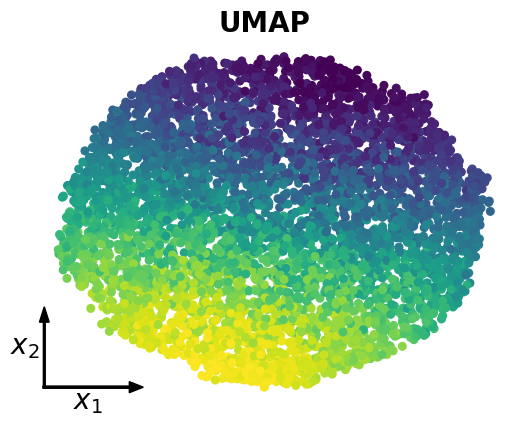

In [125]:
X_plt = S_um[:,0]
Y_plt = -S_um[:,1]
X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min-5*wid
Y_ori = Y_min

plt.scatter(X_plt,Y_plt,s=30,c=x3,cmap='viridis')
plt.axis('off')

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid,head_length=5*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid*2/3,color='black',head_width=3.5*wid,head_length=7*wid)

plt.text(X_ori+X_len/2,Y_ori-wid*10,'$x_1$',fontsize=20,ha='center',weight='bold')
plt.text(X_ori-wid*7,Y_ori+Y_len/2,'$x_2$',fontsize=20,ha='center',weight='bold')

plt.title('UMAP',fontsize=20,weight='bold')
plt.savefig(figure_path+'umap.png',dpi=600,bbox_inches='tight')

In [59]:
encoders = [0]*10
mus = [0]*10
sgms = [0]*10
latent_zs = [0]*10
for i in range(10):
    encoders[i] = torch.load(result_path+'encoder'+str(i)+'.pt')
    mu, sigma = encoders[i](torch.FloatTensor(X))
    mus[i] = mu.detach().numpy()
    sgms[i] = sigma.detach().numpy()
    latent_zs[i] = np.hstack((mus[i],sgms[i]))
encoders = np.array(encoders)
mus = np.array(mus)
sgms = np.array(sgms)
latent_zs = np.array(latent_zs)

In [60]:
# plt.scatter(
#     # X[:, 0], X[:, 1], c=crcs_smooth[6,:], s=30, alpha=0.8,cmap=cmap
#     X[:, 0], X[:, 1], c=np.mean(crcs_smooth,axis=0), s=30, alpha=0.8,cmap=cmap
# )
# plt.axis('equal')
# plt.show()

In [61]:
# plt.hist(np.mean(crcs_smooth,axis=0),bins=50)

In [62]:
import networkx as nx

G = [0]*10
for i in range(10):
    G[i] = nx.from_scipy_sparse_array(A)

In [64]:
for j in range(10):
    for i in np.array(G[j].edges):
        G[j].edges[i]['dist_fisher'] = Fisher_distz(latent_zs[j,i[0]],latent_zs[j,i[1]])
        G[j].edges[i]['dist_euclidean'] = np.linalg.norm(X[i[0],:3]-X[i[1],:3])
        G[j].edges[i]['dist_umap'] = np.linalg.norm(S_um[i[0]]-S_um[i[1]])
        G[j].edges[i]['dist_tsne'] = np.linalg.norm(S_tsne[i[0]]-S_tsne[i[1]])

In [114]:
ng = 5000
sources = np.array([np.random.choice(G[0].nodes) for _ in range(ng)])
targets = np.array([np.argmin(np.linalg.norm(X_major+X_major[sources[i]],axis=1)) for i in range(ng)])

In [115]:
spz_euc = [nx.shortest_path(G[0],source=sources[i],target=targets[i],weight='dist_euclidean') for i in range(ng)]
# spz_fisher = [nx.shortest_path(G[0],source=sources[i],target=targets[i],weight='dist_fisher') for i in range(ng)]
# spz_umap = [nx.shortest_path(G[0],source=sources[i],target=targets[i],weight='dist_umap') for i in range(ng)]

In [116]:
def path_len(G, dist, path):
    lenp = 0
    for i in range(len(path)-1):
        lenp += G.edges[path[i],path[i+1]][dist]
    return lenp

In [126]:
len_euc = np.array([path_len(G[0],'dist_euclidean',spz_euc[i]) for i in range(100)])
len_fisher = np.array([path_len(G[0],'dist_fisher',spz_euc[i]) for i in range(100)])
len_umap = np.array([path_len(G[0],'dist_umap',spz_euc[i]) for i in range(100)])
len_tsne = np.array([path_len(G[0],'dist_tsne',spz_euc[i]) for i in range(100)])
# len_fisher = np.array([path_len(G[0],'dist_fisher',spz_fisher[i]) for i in range(100)])
# len_umap = np.array([path_len(G[0],'dist_umap',spz_umap[i]) for i in range(100)])

In [132]:
str(np.std(a)/np.mean(a))

'0.021173231435400522'

In [133]:
str(np.std(b)/np.mean(b))

'0.03490245420210455'

In [134]:
str(np.std(c)/np.mean(c))

'0.08994807545949898'

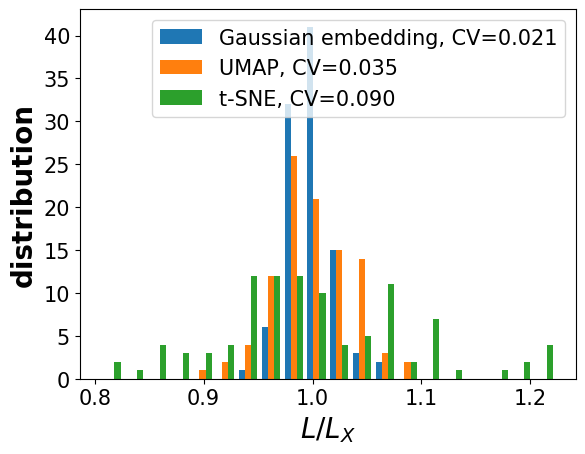

In [135]:
i = 0
a = len_fisher/len_euc
b = len_umap/len_euc
c = len_tsne/len_euc
a /= np.mean(a)
b /= np.mean(b)
c /= np.mean(c)
plt.hist([a, b, c], bins=20, label=[
    'Gaussian embedding, CV=0.021',
    'UMAP, CV=0.035',
    't-SNE, CV=0.090'])
# plt.hist([a, b], bins=20, label=['Gaussian embedding','UMAP'])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.xlabel('$L/L_X$',fontsize=20,weight='bold')
plt.ylabel('distribution',fontsize=20,weight='bold')
# xt = np.linspace(0.9,1.1,6)
# plt.xticks(xt,label=xt)
plt.savefig(figure_path+'dr.png',dpi=600,bbox_inches='tight')